In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [3]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of tabular data: spotify-2023-short.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/spotify-2023-short.csv

File ‘spotify-2023-short.csv’ already there; not retrieving.



I0000 00:00:1738887564.853832 19706460 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [5]:
dataset = rf.Dataset.from_csv("Spotify", "spotify-2023-short.csv")
dataset.to_pandas()

,released_year,released_month,released_day,in_spotify_playlists,bpm,key,mode
0,2023,7,14,553,125,B,Major
1,2023,3,23,1474,92,C#,Major
2,2023,6,30,1397,138,F,Major
3,2019,8,23,7858,170,A,Major
4,2023,5,18,3133,144,A,Minor
...,...,...,...,...,...,...,...
95,2023,5,12,2175,143,D#,Major
96,2023,3,17,2000,100,F#,Minor
97,2022,12,9,2839,143,F,Major
98,2011,1,1,20333,112,C#,Minor


In [6]:
cat_fields = "released_year released_month released_day key mode".split()
con_fields = "in_spotify_playlists bpm".split()
config = {
    "encoder": {
        "metadata": [
            {"field": col, "type": "categorical"} for col in cat_fields
        ]
        + [{"field": col, "type": "continuous"} for col in con_fields]
    },
    "rtf": {
        "mode": "tabular",
        "num_bootstrap": 2,
        "tabular": {
            "epochs": 1,
            "transformer": {
                "gpt2_config": {"layer": 1, "head": 1, "embed": 1}
            },
        },
    },
}
# create the train action
train = ra.TrainTransformer(config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

Workflow: 4hJ0Rbycwsgqlb6njuu59I


In [8]:
async for log in workflow.logs():
    print(log)

2025-02-07T00:19:25Z dataset-load: INFO Downloading dataset '1l3zkupR9jay5fxPrcfWNA'
2025-02-07T00:19:26Z dataset-load: INFO Downloaded dataset '1l3zkupR9jay5fxPrcfWNA' with 100 rows
2025-02-07T00:19:26Z train-transformer: WARN Missing values detected in Field "key".
2025-02-07T00:19:26Z train-transformer: INFO Start training...
2025-02-07T00:19:28Z train-transformer: INFO Epoch 1 completed.
2025-02-07T00:19:38Z train-transformer: INFO Training completed. The Model ID is 369fe009-e4e9-11ef-a0ee-0e92d88750cd


In [9]:
model = await workflow.models().last()
model

Model(id='369fe009-e4e9-11ef-a0ee-0e92d88750cd', labels={'workflow_id': '4hJ0Rbycwsgqlb6njuu59I'}, create_time=datetime.datetime(2025, 2, 7, 0, 19, 36, tzinfo=datetime.timezone.utc), size_bytes=127776256)

In [ ]:
generate = ra.GenerateTransformer(config)
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(target=200)
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 4lw6cEACXNy8vkS7JUHwyv


In [11]:
async for log in workflow.logs():
    print(log)

2025-02-07T00:19:42Z generate-transformer: INFO Starting download of Model 369fe009-e4e9-11ef-a0ee-0e92d88750cd
2025-02-07T00:19:48Z generate-transformer: INFO Finished download of Model 369fe009-e4e9-11ef-a0ee-0e92d88750cd
2025-02-07T00:19:48Z generate-transformer: INFO Start generating samples...
2025-02-07T00:19:49Z generate-transformer: INFO Finish generating samples...
2025-02-07T00:19:49Z session-target: INFO new=100 total=100 needs=100
2025-02-07T00:19:49Z generate-transformer: INFO Starting download of Model 369fe009-e4e9-11ef-a0ee-0e92d88750cd
2025-02-07T00:19:49Z dataset-save: INFO Saved dataset '3B9hr2c3KQro4NQIGYsNri' with 100 rows
2025-02-07T00:19:56Z generate-transformer: INFO Finished download of Model 369fe009-e4e9-11ef-a0ee-0e92d88750cd
2025-02-07T00:19:57Z generate-transformer: INFO Start generating samples...
2025-02-07T00:19:57Z generate-transformer: INFO Finish generating samples...
2025-02-07T00:19:57Z session-target: INFO new=100 total=200 needs=0


In [12]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,released_year,released_month,released_day,key,mode,in_spotify_playlists,bpm
0,2019,3,27,A#,Minor,2833,128
1,2020,12,0,C#,Minor,7018,130
2,2007,7,5,G#,Major,15471,40
3,2093,3,23,A#,Minor,16972,130
4,2025,2,20,A#,Minor,6603,88
...,...,...,...,...,...,...,...
195,2000,3,20,A,Minor,17700,177
196,2020,2,7,D,Minor,8062,181
197,2012,0,25,None,Major,7577,160
198,2023,2,5,G,Major,2058,126


### Evaluation

**1. Categorical columns**


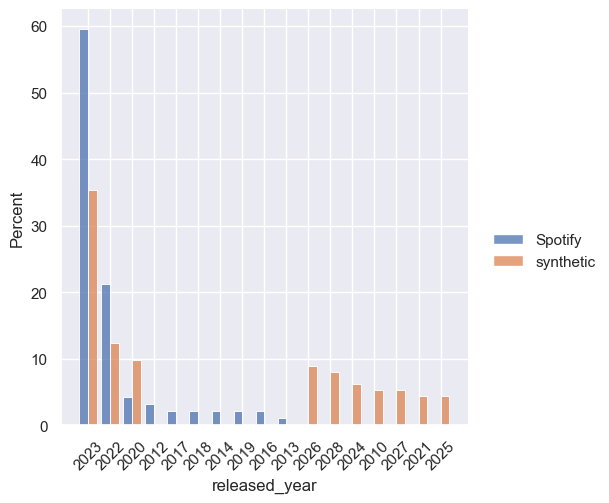

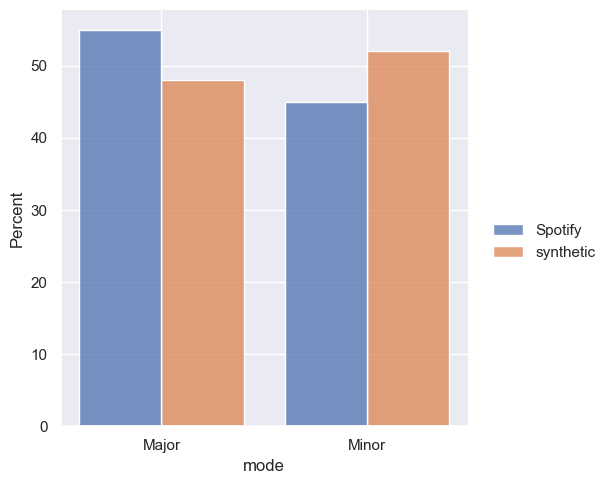

In [13]:
for col in ["released_year", "mode"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")

**2. numerical columns**


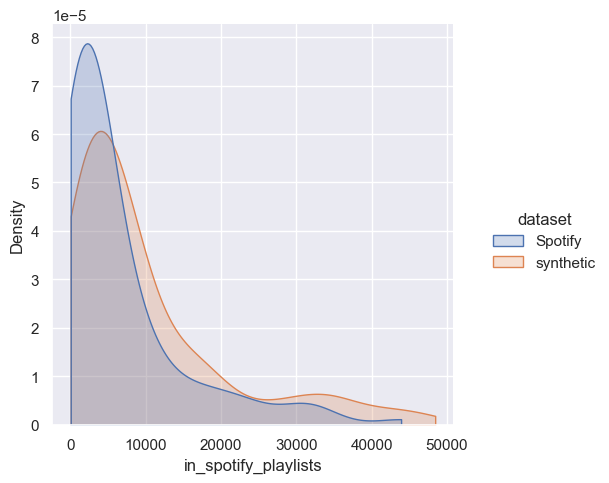

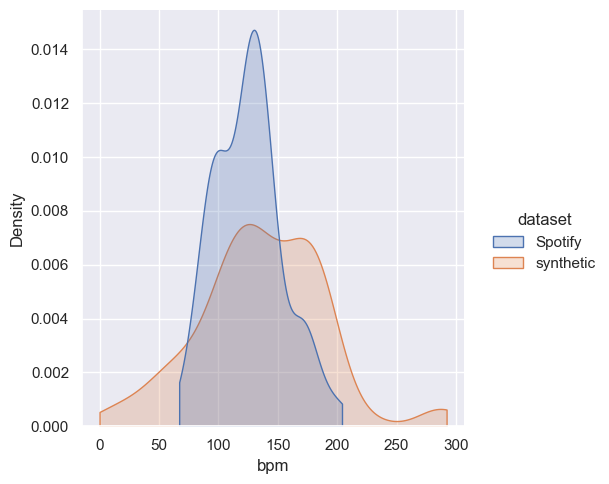

In [14]:
for col in ["in_spotify_playlists", "bpm"]:
    rf.labs.vis.plot_kde([dataset, syn], col)